In [2]:
# USE THIS to make full-width cells
from IPython.core.display import display, HTML
import IPython as IPy
# import tabulate
display(HTML("<style>.container { width:100% !important; }</style>"))

**Chapter 17 – Autoencoders and GANs**

_This notebook contains all the sample code in chapter 17._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

A couple utility functions to plot grayscale 28x28 image:

In [4]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

# PCA with a linear Autoencoder

Build 3D dataset:

In [5]:
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

# X_train = generate_3d_data(60)
X_train = generate_3d_data(600)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

Now let's build the Autoencoder...

### bstudent NOTE:

autoencoder is implemented as a sequence of two sub-models.  

encoder and decoder have symmetric shapes.  

they are provided as 2 separable networks so that we can examine the "compressed" output of the encoder layer after training is complete.  

think of it as compression and decompression, we want to base performance / loss on the total round-trip performance, but when used in an application we want to compress and decompress separately.


**see caption for plot below**

In [33]:
np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1.5))

In [34]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Train on 600 samples
Epoch 1/20
600/600 [==============================] - 0s 305us/sample - loss: 0.0986
Epoch 2/20
600/600 [==============================] - 0s 40us/sample - loss: 0.0235
Epoch 3/20
600/600 [==============================] - 0s 47us/sample - loss: 0.0058
Epoch 4/20
600/600 [==============================] - 0s 46us/sample - loss: 0.0049
Epoch 5/20
600/600 [==============================] - 0s 41us/sample - loss: 0.0037
Epoch 6/20
600/600 [==============================] - 0s 44us/sample - loss: 0.0037
Epoch 7/20
600/600 [==============================] - 0s 46us/sample - loss: 0.0038
Epoch 8/20
600/600 [==============================] - 0s 42us/sample - loss: 0.0033
Epoch 9/20
600/600 [==============================] - 0s 47us/sample - loss: 0.0033
Epoch 10/20
600/600 [==============================] - 0s 42us/sample - loss: 0.0032
Epoch 11/20
600/600 [==============================] - 0s 46us/sample - loss: 0.0033
Epoch 12/20
600/600 [==============================]

### bstudent NOTE:

**`codings`** comprises the "middle" of the autoencoder, i.e. it's just the output of the encoder half

In [35]:
codings = encoder.predict(X_train)

Saving figure linear_autoencoder_pca_plot


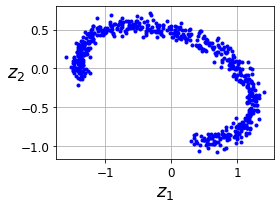

In [36]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
save_fig("linear_autoencoder_pca_plot")
plt.show()

## bstudent: **Experiment:** let's see how the network weights compare to eigvectors

Note that since activation is linear, encode and decoder should probably be similar within the limits of
the small sample size, as well as being similar to eigenvectors with the same limitations. 

### TEST: cranked up to 600 samples from original 60

In [73]:
# Problem: How to extract weights from encoder and decoder?
# ==> how to get weights from tf.keras.layer as numpy-ish array?
# Answer: (1) <model>.weights is a list of weights in each layer of the model
#         (2) for layer i, call its method <model>.weights[i].numpy() to get 
#             numpy representation

encw = encoder.weights[0].numpy()
decw = decoder.weights[0].numpy()

print(f"{encw}\n{decw.T}")
# X_train
# Simple check:
# encw2 = encw.T.dot(encw)
print("\nself-orthogonality check:")
print(f"{encw.T.dot(encw).round(2)}\n{decw.dot(decw.T).round(2)}")
print("\nencoder-decoder mutual orthogonality check:")
print(f"{decw.dot(encw).round(2)}")
print()
e1d = np.sqrt(np.diag(encw.T.dot(encw)))
enc1 = encw / e1d
print((enc1.T.dot(enc1)).round(2))
print()
d1d = np.sqrt(np.diag(decw.dot(decw.T)))
dec1 = (decw.T / d1d).T
print((dec1.dot(dec1.T)).round(2))

U, sss, Vt =  np.linalg.svd(X_train.T, full_matrices=False)

print(f"U=\n{U.round(2)}\nenc1=\n{enc1.round(2)}\ndec1.T=\n{dec1.T.round(2)}")

print(f"enc1.T*U=\n{(enc1.T.dot(U)).round(2)}\ndec*U=\n{(dec1.dot(U)).round(2)}")

# The sum of the normalized eigenvectors are orthogonal

eplusdT =(enc1+dec1.T)/2

print(f"eplusdT.T.dot(eplusdT)=\n{(eplusdT.T.dot(eplusdT)).round(2)}")

# The weight columns need to be normalized for that to work:
encplusdecT = (encw+decw.T)/2
print(f"encplusdecT.T.dot(encplusdecT)=\n{(encplusdecT.T.dot(encplusdecT)).round(2)}")

[[ 0.9461082  -0.705308  ]
 [ 0.5536143   0.84744036]
 [ 0.18885843  0.2869506 ]]
[[ 0.71194917 -0.46430388]
 [ 0.5213537   0.71986544]
 [ 0.21154031  0.21587978]]

self-orthogonality check:
[[ 1.24 -0.14]
 [-0.14  1.3 ]]
[[0.82 0.09]
 [0.09 0.78]]

encoder-decoder mutual orthogonality check:
[[1. 0.]
 [0. 1.]]

[[ 1.   -0.11]
 [-0.11  1.  ]]

[[1.   0.11]
 [0.11 1.  ]]
U=
[[-0.94  0.33 -0.09]
 [-0.29 -0.91 -0.31]
 [-0.18 -0.27  0.95]]
enc1=
[[ 0.85 -0.62]
 [ 0.5   0.74]
 [ 0.17  0.25]]
dec1.T=
[[ 0.78 -0.53]
 [ 0.57  0.81]
 [ 0.23  0.24]]
enc1.T*U=
[[-0.97 -0.22 -0.07]
 [ 0.32 -0.94  0.06]]
dec*U=
[[-0.94 -0.33 -0.03]
 [ 0.22 -0.98  0.02]]
eplusdT.T.dot(eplusdT)=
[[ 1. -0.]
 [-0.  1.]]
encplusdecT.T.dot(encplusdecT)=
[[ 1.02 -0.01]
 [-0.01  1.02]]


In [74]:
xxx = np.asarray([[2,3,4],[2,3,4],[2,3,4]])
yyy = np.asarray([2,3,1])

xxx / yyy

# xxx

array([[1., 1., 4.],
       [1., 1., 4.],
       [1., 1., 4.]])

# Stacked Autoencoders

Let's use MNIST:

In [8]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

## Train all layers at once

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [6]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [77]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 4s 78us/sample - loss: 0.3376 - rounded_accuracy: 0.8874 - val_loss: 0.3113 - val_rounded_accuracy: 0.9123
Epoch 2/20
55000/55000 [==============================] - 4s 69us/sample - loss: 0.3053 - rounded_accuracy: 0.9154 - val_loss: 0.3027 - val_rounded_accuracy: 0.9195
Epoch 3/20
55000/55000 [==============================] - 4s 71us/sample - loss: 0.2988 - rounded_accuracy: 0.9212 - val_loss: 0.2980 - val_rounded_accuracy: 0.9217
Epoch 4/20
55000/55000 [==============================] - 4s 71us/sample - loss: 0.2950 - rounded_accuracy: 0.9248 - val_loss: 0.2982 - val_rounded_accuracy: 0.9254
Epoch 5/20
55000/55000 [==============================] - 4s 72us/sample - loss: 0.2923 - rounded_accuracy: 0.9272 - val_loss: 0.2934 - val_rounded_accuracy: 0.9253
Epoch 6/20
55000/55000 [==============================] - 4s 71us/sample - loss: 0.2905 - rounded_accuracy: 0.9288 - val_loss:

This function processes a few test images through the autoencoder and displays the original images and their reconstructions:

In [9]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

Saving figure reconstruction_plot


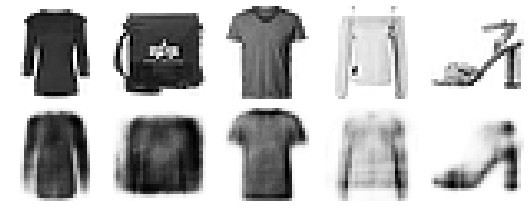

In [79]:
show_reconstructions(stacked_ae)
save_fig("reconstruction_plot")

# Visualizing Fashion MNIST

In [80]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

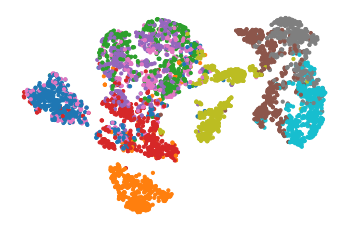

In [81]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

Let's make this diagram a bit prettier:

Saving figure fashion_mnist_visualization_plot


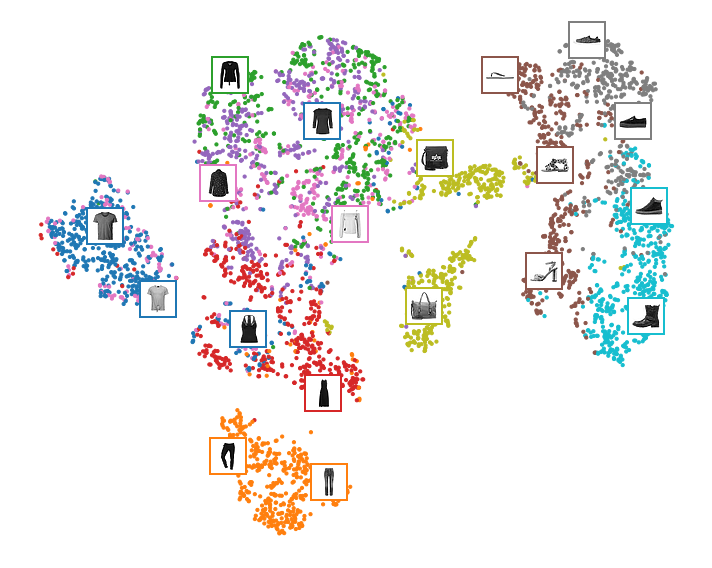

In [82]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()

### Make a denser plot

Saving figure fashion_mnist_visualization_plot


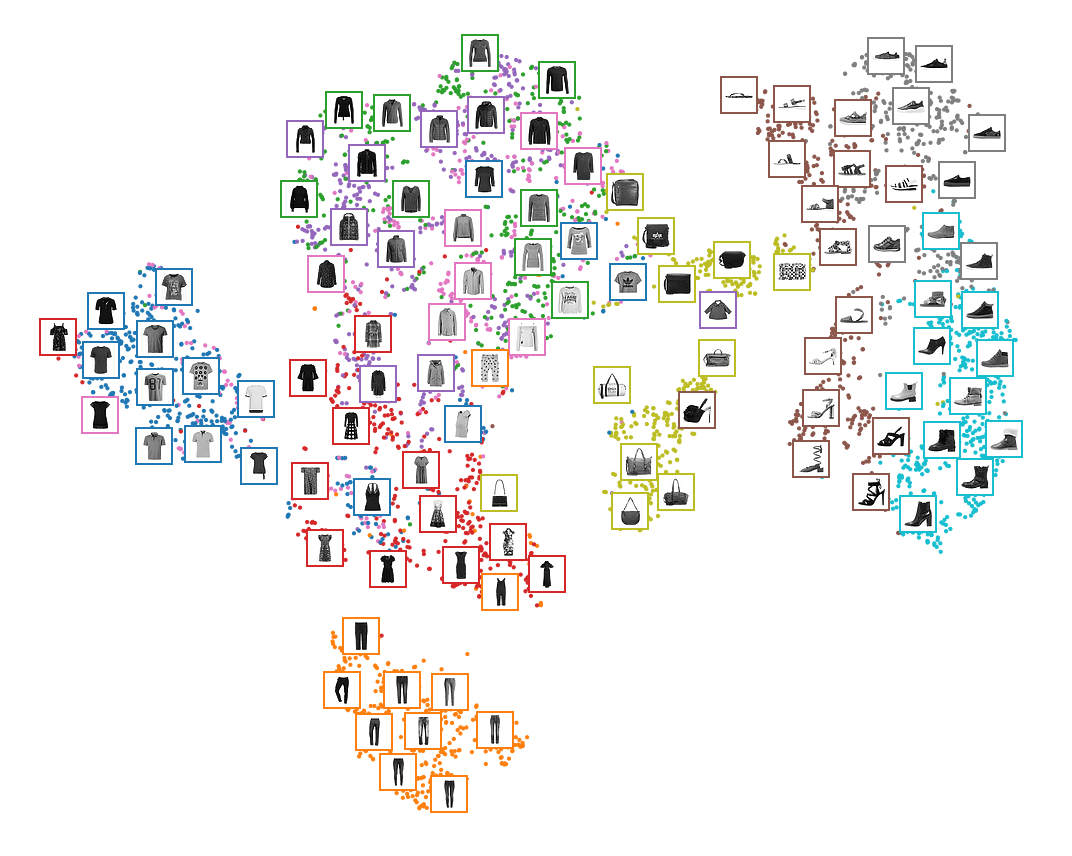

In [88]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(15, 12))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.0025: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()

# bstudent NOTE: Good example of something "complex" but useful in Keras

Following along with how the undelying layer is re-used twice in the network gives a good idea of the internals and where / how the mutable-reference property of the weights affect network architecture.

## Tying weights

It is common to tie the weights of the encoder and the decoder, by simply using the transpose of the encoder's weights as the decoder weights. For this, we need to use a custom layer.

### bstudent NOTE: would be interesting to try this on the eigensystem problem explored above

In [89]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [93]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# dense_1 = keras.layers.Dense(100, activation="selu")
# dense_2 = keras.layers.Dense(30, activation="selu")
dense_1 = keras.layers.Dense(150, activation="selu")
dense_2 = keras.layers.Dense(60, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 83us/sample - loss: 0.3182 - rounded_accuracy: 0.9045 - val_loss: 0.2946 - val_rounded_accuracy: 0.9283
Epoch 2/10
55000/55000 [==============================] - 4s 71us/sample - loss: 0.2894 - rounded_accuracy: 0.9308 - val_loss: 0.2871 - val_rounded_accuracy: 0.9347
Epoch 3/10
55000/55000 [==============================] - 4s 73us/sample - loss: 0.2837 - rounded_accuracy: 0.9362 - val_loss: 0.2848 - val_rounded_accuracy: 0.9335
Epoch 4/10
55000/55000 [==============================] - 4s 72us/sample - loss: 0.2805 - rounded_accuracy: 0.9393 - val_loss: 0.2815 - val_rounded_accuracy: 0.9416
Epoch 5/10
55000/55000 [==============================] - 4s 71us/sample - loss: 0.2783 - rounded_accuracy: 0.9415 - val_loss: 0.2788 - val_rounded_accuracy: 0.9435
Epoch 6/10
55000/55000 [==============================] - 4s 69us/sample - loss: 0.2769 - rounded_accuracy: 0.9428 - val_loss:

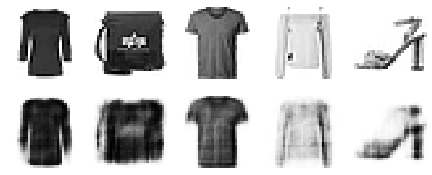

In [94]:
show_reconstructions(tied_ae)
plt.show()

## Training one Autoencoder at a Time

In [91]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer,
                      n_epochs=10, output_activation=None, metrics=None):
    n_inputs = X_train.shape[-1]
    encoder = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation="selu", input_shape=[n_inputs])
    ])
    decoder = keras.models.Sequential([
        keras.layers.Dense(n_inputs, activation=output_activation),
    ])
    autoencoder = keras.models.Sequential([encoder, decoder])
    autoencoder.compile(optimizer, loss, metrics=metrics)
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=[X_valid, X_valid])
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [95]:
tf.random.set_seed(42)
np.random.seed(42)

K = keras.backend
X_train_flat = K.batch_flatten(X_train) # equivalent to .reshape(-1, 28 * 28)
X_valid_flat = K.batch_flatten(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat, "binary_crossentropy",
    keras.optimizers.SGD(lr=1.5), output_activation="sigmoid",
    metrics=[rounded_accuracy])
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, "mse", keras.optimizers.SGD(lr=0.05),
    output_activation="selu")

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 4s 66us/sample - loss: 0.3446 - rounded_accuracy: 0.8874 - val_loss: 0.3122 - val_rounded_accuracy: 0.9147
Epoch 2/10
55000/55000 [==============================] - 3s 57us/sample - loss: 0.3040 - rounded_accuracy: 0.9203 - val_loss: 0.3007 - val_rounded_accuracy: 0.9244
Epoch 3/10
55000/55000 [==============================] - 3s 58us/sample - loss: 0.2950 - rounded_accuracy: 0.9284 - val_loss: 0.2936 - val_rounded_accuracy: 0.9310
Epoch 4/10
55000/55000 [==============================] - 3s 58us/sample - loss: 0.2892 - rounded_accuracy: 0.9340 - val_loss: 0.2889 - val_rounded_accuracy: 0.9359
Epoch 5/10
55000/55000 [==============================] - 3s 58us/sample - loss: 0.2855 - rounded_accuracy: 0.9377 - val_loss: 0.2858 - val_rounded_accuracy: 0.9386
Epoch 6/10
55000/55000 [==============================] - 3s 58us/sample - loss: 0.2828 - rounded_accuracy: 0.9402 - val_loss:

In [96]:
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc1, enc2, dec2, dec1,
    keras.layers.Reshape([28, 28])
])

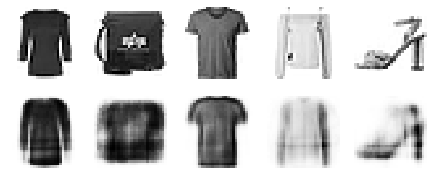

In [97]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

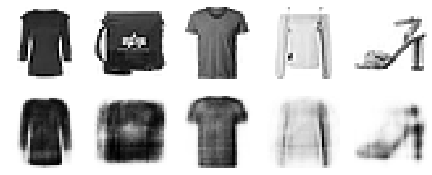

In [99]:
ae_01 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc1, dec1,
    keras.layers.Reshape([28, 28])
])

show_reconstructions(ae_01)
plt.show()

In [101]:
stacked_ae_1_by_1.compile(loss="binary_crossentropy",
                          optimizer=keras.optimizers.SGD(lr=0.1), metrics=[rounded_accuracy])
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=10,
                                validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 4s 81us/sample - loss: 0.2852 - rounded_accuracy: 0.9360 - val_loss: 0.2868 - val_rounded_accuracy: 0.9359
Epoch 2/10
55000/55000 [==============================] - 4s 71us/sample - loss: 0.2849 - rounded_accuracy: 0.9364 - val_loss: 0.2866 - val_rounded_accuracy: 0.9360
Epoch 3/10
55000/55000 [==============================] - 4s 70us/sample - loss: 0.2847 - rounded_accuracy: 0.9366 - val_loss: 0.2864 - val_rounded_accuracy: 0.9361
Epoch 4/10
55000/55000 [==============================] - 4s 71us/sample - loss: 0.2845 - rounded_accuracy: 0.9368 - val_loss: 0.2862 - val_rounded_accuracy: 0.9365
Epoch 5/10
55000/55000 [==============================] - 4s 71us/sample - loss: 0.2844 - rounded_accuracy: 0.9369 - val_loss: 0.2861 - val_rounded_accuracy: 0.9365
Epoch 6/10
55000/55000 [==============================] - 4s 70us/sample - loss: 0.2842 - rounded_accuracy: 0.9371 - val_loss:

## Using Convolutional Layers Instead of Dense Layers

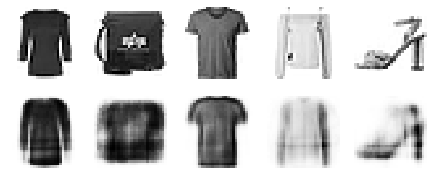

In [97]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [10]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 9s 171us/sample - loss: 0.3020 - rounded_accuracy: 0.9186 - val_loss: 0.2800 - val_rounded_accuracy: 0.9395
Epoch 2/5
55000/55000 [==============================] - 8s 140us/sample - loss: 0.2755 - rounded_accuracy: 0.9412 - val_loss: 0.2731 - val_rounded_accuracy: 0.9453
Epoch 3/5
55000/55000 [==============================] - 9s 164us/sample - loss: 0.2707 - rounded_accuracy: 0.9463 - val_loss: 0.2705 - val_rounded_accuracy: 0.9474
Epoch 4/5
55000/55000 [==============================] - 8s 154us/sample - loss: 0.2681 - rounded_accuracy: 0.9491 - val_loss: 0.2676 - val_rounded_accuracy: 0.9516
Epoch 5/5
55000/55000 [==============================] - 9s 155us/sample - loss: 0.2663 - rounded_accuracy: 0.9510 - val_loss: 0.2695 - val_rounded_accuracy: 0.9492


In [11]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0

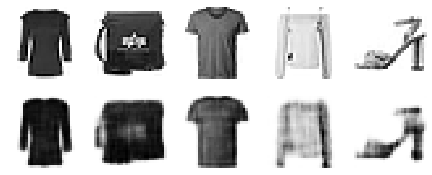

In [12]:
show_reconstructions(conv_ae)
plt.show()

## bstudent COMPARISON: below is image reconstruction from a prior non-convolutional AE 

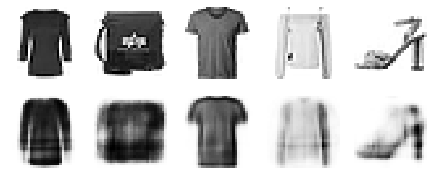

In [102]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

# Recurrent Autoencoders

In [28]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
    keras.layers.LSTM(30)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])

In [29]:
history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 79s 1ms/sample - loss: 0.5165 - rounded_accuracy: 0.7363 - val_loss: 0.4489 - val_rounded_accuracy: 0.8137
Epoch 2/10
55000/55000 [==============================] - 78s 1ms/sample - loss: 0.4049 - rounded_accuracy: 0.8415 - val_loss: 0.3762 - val_rounded_accuracy: 0.8650
Epoch 3/10
55000/55000 [==============================] - 80s 1ms/sample - loss: 0.3662 - rounded_accuracy: 0.8703 - val_loss: 0.3626 - val_rounded_accuracy: 0.8730
Epoch 4/10
55000/55000 [==============================] - 80s 1ms/sample - loss: 0.3505 - rounded_accuracy: 0.8808 - val_loss: 0.3483 - val_rounded_accuracy: 0.8838
Epoch 5/10
55000/55000 [==============================] - 82s 1ms/sample - loss: 0.3398 - rounded_accuracy: 0.8881 - val_loss: 0.3345 - val_rounded_accuracy: 0.8941
Epoch 6/10
55000/55000 [==============================] - 93s 2ms/sample - loss: 0.3328 - rounded_accuracy: 0.8930 - val_loss:

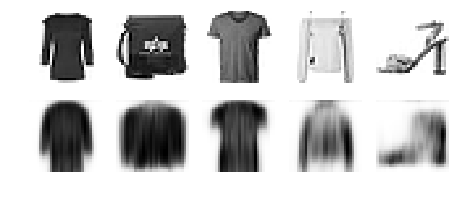

In [30]:
show_reconstructions(recurrent_ae)
plt.show()

# Stacked denoising Autoencoder

## bstudent NOTE: this is not really "Denoising", more a dropout-like regularization

Just looking at the docs without digging into the code or making a diagnostic script, the "GaussianNoise" layer (see: https://keras.io/layers/noise/ ) appears to add a different sample of noise to each presentation of sample j, and the doc refers to it as *"a form of random data augmentation."*

So it's a useful technique, but to provide degredation rather than benefit, then if varying with each presentation of sample j, noise should have magnitude that produces overhwhelmingly low SNR, or should be the same for each  presentation of image j (i.e. effectively a random pattern overlaid on each training image).

Using Gaussian noise:

In [14]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 82us/sample - loss: 0.3494 - rounded_accuracy: 0.8779 - val_loss: 0.3163 - val_rounded_accuracy: 0.9075
Epoch 2/10
55000/55000 [==============================] - 4s 72us/sample - loss: 0.3120 - rounded_accuracy: 0.9097 - val_loss: 0.3086 - val_rounded_accuracy: 0.9126
Epoch 3/10
55000/55000 [==============================] - 4s 74us/sample - loss: 0.3060 - rounded_accuracy: 0.9149 - val_loss: 0.3047 - val_rounded_accuracy: 0.9151
Epoch 4/10
55000/55000 [==============================] - 4s 72us/sample - loss: 0.3023 - rounded_accuracy: 0.9181 - val_loss: 0.3002 - val_rounded_accuracy: 0.9219
Epoch 5/10
55000/55000 [==============================] - 4s 72us/sample - loss: 0.2996 - rounded_accuracy: 0.9205 - val_loss: 0.2976 - val_rounded_accuracy: 0.9247
Epoch 6/10
55000/55000 [==============================] - 4s 75us/sample - loss: 0.2977 - rounded_accuracy: 0.9222 - val_loss:

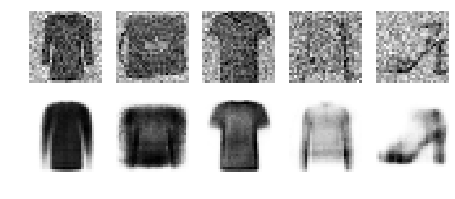

In [32]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()

## bstudent COMPARISON: below is image reconstruction from a prior non-convolutional AE 

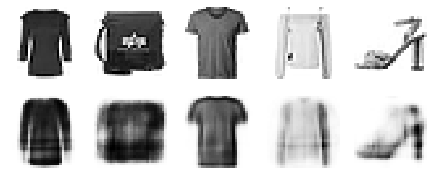

In [102]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

Using dropout:

In [15]:
tf.random.set_seed(42)
np.random.seed(42)

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                   metrics=[rounded_accuracy])
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 83us/sample - loss: 0.3554 - rounded_accuracy: 0.8721 - val_loss: 0.3188 - val_rounded_accuracy: 0.9057
Epoch 2/10
55000/55000 [==============================] - 4s 72us/sample - loss: 0.3179 - rounded_accuracy: 0.9034 - val_loss: 0.3115 - val_rounded_accuracy: 0.9117
Epoch 3/10
55000/55000 [==============================] - 4s 73us/sample - loss: 0.3124 - rounded_accuracy: 0.9079 - val_loss: 0.3070 - val_rounded_accuracy: 0.9144
Epoch 4/10
55000/55000 [==============================] - 4s 73us/sample - loss: 0.3089 - rounded_accuracy: 0.9107 - val_loss: 0.3039 - val_rounded_accuracy: 0.9173
Epoch 5/10
55000/55000 [==============================] - 4s 77us/sample - loss: 0.3065 - rounded_accuracy: 0.9126 - val_loss: 0.3016 - val_rounded_accuracy: 0.9198
Epoch 6/10
55000/55000 [==============================] - 4s 73us/sample - loss: 0.3047 - rounded_accuracy: 0.9141 - val_loss:

Saving figure dropout_denoising_plot


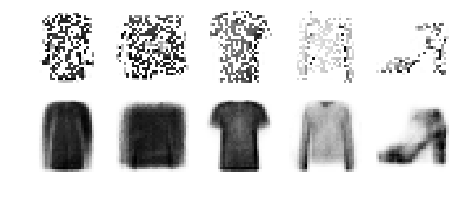

In [34]:
tf.random.set_seed(42)
np.random.seed(42)

dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))
save_fig("dropout_denoising_plot", tight_layout=False)

# Sparse Autoencoder

Let's build a simple stacked autoencoder, so we can compare it to the sparse autoencoders we will build. This time we will use the sigmoid activation function for the coding layer, to ensure that the coding values range from 0 to 1:

In [16]:
tf.random.set_seed(42)
np.random.seed(42)

simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="sigmoid"),
])
simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
simple_ae = keras.models.Sequential([simple_encoder, simple_decoder])
simple_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.),
                  metrics=[rounded_accuracy])
history = simple_ae.fit(X_train, X_train, epochs=10,
                        validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 4s 77us/sample - loss: 0.4326 - rounded_accuracy: 0.7948 - val_loss: 0.3773 - val_rounded_accuracy: 0.8503
Epoch 2/10
55000/55000 [==============================] - 4s 69us/sample - loss: 0.3610 - rounded_accuracy: 0.8670 - val_loss: 0.3508 - val_rounded_accuracy: 0.8783
Epoch 3/10
55000/55000 [==============================] - 4s 69us/sample - loss: 0.3402 - rounded_accuracy: 0.8861 - val_loss: 0.3360 - val_rounded_accuracy: 0.8873
Epoch 4/10
55000/55000 [==============================] - 4s 68us/sample - loss: 0.3273 - rounded_accuracy: 0.8968 - val_loss: 0.3248 - val_rounded_accuracy: 0.9007
Epoch 5/10
55000/55000 [==============================] - 4s 69us/sample - loss: 0.3207 - rounded_accuracy: 0.9016 - val_loss: 0.3211 - val_rounded_accuracy: 0.9047
Epoch 6/10
55000/55000 [==============================] - 4s 69us/sample - loss: 0.3173 - rounded_accuracy: 0.9041 - val_loss:

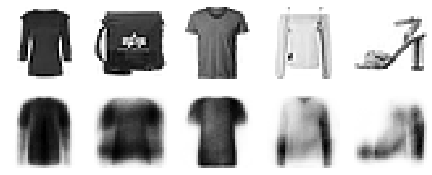

In [17]:
show_reconstructions(simple_ae)
plt.show()

Let's create a couple functions to print nice activation histograms:

In [18]:
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)

In [19]:
def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])

Let's use these functions to plot histograms of the activations of the encoding layer. The histogram on the left shows the distribution of all the activations. You can see that values close to 0 or 1 are more frequent overall, which is consistent with the saturating nature of the sigmoid function. The histogram on the right shows the distribution of mean neuron activations: you can see that most neurons have a mean activation close to 0.5. Both histograms tell us that each neuron tends to either fire close to 0 or 1, with about 50% probability each. However, some neurons fire almost all the time (right side of the right histogram).

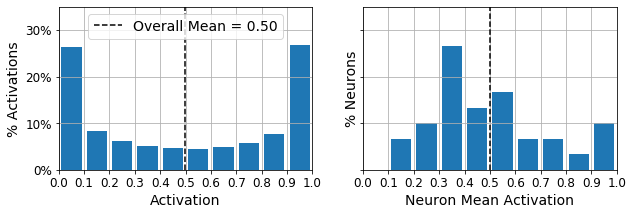

In [20]:
plot_activations_histogram(simple_encoder, height=0.35)
plt.show()

Now let's add $\ell_1$ regularization to the coding layer:

In [21]:
tf.random.set_seed(42)
np.random.seed(42)

sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid"),
    keras.layers.ActivityRegularization(l1=1e-3)  # Alternatively, you could add
                                                  # activity_regularizer=keras.regularizers.l1(1e-3)
                                                  # to the previous layer.
])
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 4s 80us/sample - loss: 0.4307 - rounded_accuracy: 0.8133 - val_loss: 0.3801 - val_rounded_accuracy: 0.8590
Epoch 2/10
55000/55000 [==============================] - 4s 71us/sample - loss: 0.3691 - rounded_accuracy: 0.8690 - val_loss: 0.3644 - val_rounded_accuracy: 0.8715
Epoch 3/10
55000/55000 [==============================] - 4s 73us/sample - loss: 0.3554 - rounded_accuracy: 0.8789 - val_loss: 0.3530 - val_rounded_accuracy: 0.8764
Epoch 4/10
55000/55000 [==============================] - 4s 73us/sample - loss: 0.3442 - rounded_accuracy: 0.8870 - val_loss: 0.3426 - val_rounded_accuracy: 0.8881
Epoch 5/10
55000/55000 [==============================] - 4s 70us/sample - loss: 0.3368 - rounded_accuracy: 0.8926 - val_loss: 0.3412 - val_rounded_accuracy: 0.8957
Epoch 6/10
55000/55000 [==============================] - 4s 71us/sample - loss: 0.3307 - rounded_accuracy: 0.8981 - val_loss:

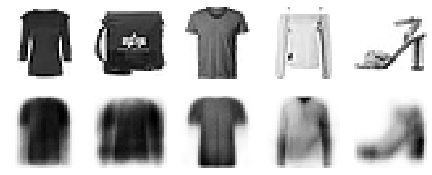

In [22]:
show_reconstructions(sparse_l1_ae)

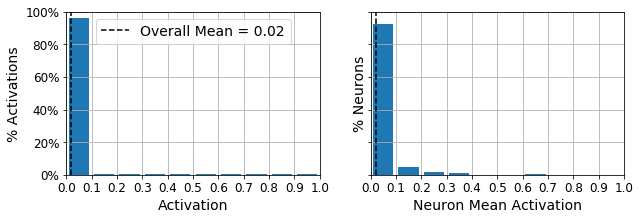

In [23]:
plot_activations_histogram(sparse_l1_encoder, height=1.)
plt.show()

Let's use the KL Divergence loss instead to ensure sparsity, and target 10% sparsity rather than 0%:

Saving figure sparsity_loss_plot


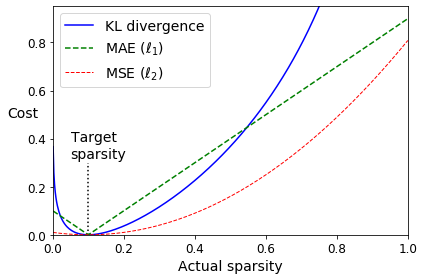

In [24]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])
save_fig("sparsity_loss_plot")

In [25]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

In [26]:
tf.random.set_seed(42)
np.random.seed(42)

kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
              metrics=[rounded_accuracy])
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 91us/sample - loss: 0.4151 - rounded_accuracy: 0.8121 - val_loss: 0.3715 - val_rounded_accuracy: 0.8569
Epoch 2/10
55000/55000 [==============================] - 4s 78us/sample - loss: 0.3532 - rounded_accuracy: 0.8762 - val_loss: 0.3443 - val_rounded_accuracy: 0.8845
Epoch 3/10
55000/55000 [==============================] - 4s 82us/sample - loss: 0.3339 - rounded_accuracy: 0.8920 - val_loss: 0.3292 - val_rounded_accuracy: 0.8964
Epoch 4/10
55000/55000 [==============================] - 4s 80us/sample - loss: 0.3222 - rounded_accuracy: 0.9018 - val_loss: 0.3213 - val_rounded_accuracy: 0.9046
Epoch 5/10
55000/55000 [==============================] - 4s 80us/sample - loss: 0.3169 - rounded_accuracy: 0.9062 - val_loss: 0.3173 - val_rounded_accuracy: 0.9061
Epoch 6/10
55000/55000 [==============================] - 4s 79us/sample - loss: 0.3135 - rounded_accuracy: 0.9093 - val_loss:

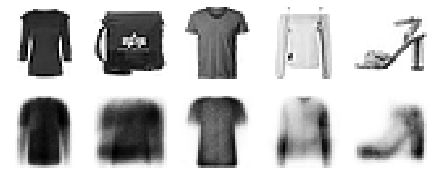

In [27]:
show_reconstructions(sparse_kl_ae)

Saving figure sparse_autoencoder_plot


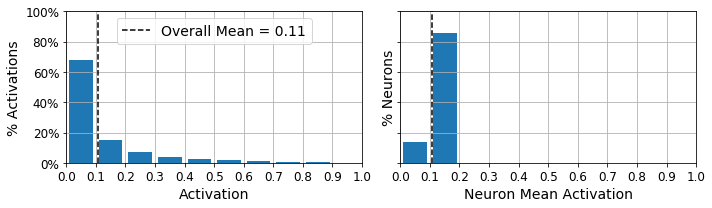

In [28]:
plot_activations_histogram(sparse_kl_encoder)
save_fig("sparse_autoencoder_plot")
plt.show()

# Variational Autoencoder

In [29]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

In [30]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 3s 52us/sample - loss: 0.3903 - rounded_accuracy: 0.8602 - val_loss: 0.3599 - val_rounded_accuracy: 0.8885
Epoch 2/25
55000/55000 [==============================] - 2s 32us/sample - loss: 0.3424 - rounded_accuracy: 0.8981 - val_loss: 0.3349 - val_rounded_accuracy: 0.9057
Epoch 3/25
55000/55000 [==============================] - 2s 31us/sample - loss: 0.3326 - rounded_accuracy: 0.9053 - val_loss: 0.3326 - val_rounded_accuracy: 0.9083
Epoch 4/25
55000/55000 [==============================] - 2s 31us/sample - loss: 0.3276 - rounded_accuracy: 0.9094 - val_loss: 0.3309 - val_rounded_accuracy: 0.9035
Epoch 5/25
55000/55000 [==============================] - 2s 32us/sample - loss: 0.3244 - rounded_accuracy: 0.9119 - val_loss: 0.3269 - val_rounded_accuracy: 0.9076
Epoch 6/25
55000/55000 [==============================] - 2s 31us/sample - loss: 0.3222 - rounded_accuracy: 0.9139 - val_loss:

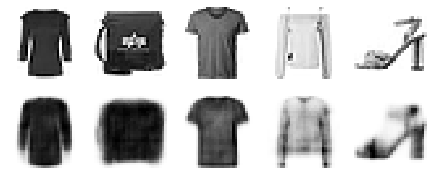

In [31]:
show_reconstructions(variational_ae)
plt.show()

## Generate Fashion Images

In [32]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

Let's generate a few random codings, decode them and plot the resulting images:

Saving figure vae_generated_images_plot


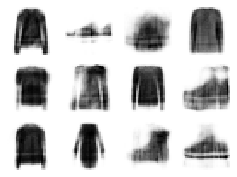

In [39]:
# tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
save_fig("vae_generated_images_plot", tight_layout=False)

Now let's perform semantic interpolation between these images:

Saving figure semantic_interpolation_plot


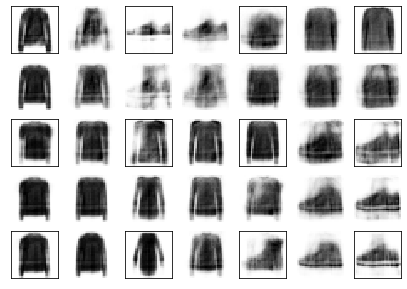

In [40]:
tf.random.set_seed(42)
np.random.seed(42)

codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")
save_fig("semantic_interpolation_plot", tight_layout=False)

# Generative Adversarial Networks

In [41]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [42]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [43]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [44]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)                     # not shown
        plt.show()                                                    # not shown

Epoch 1/1


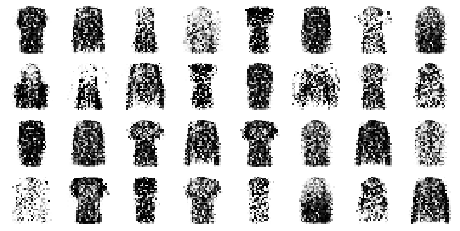

In [45]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

Saving figure gan_generated_images_plot


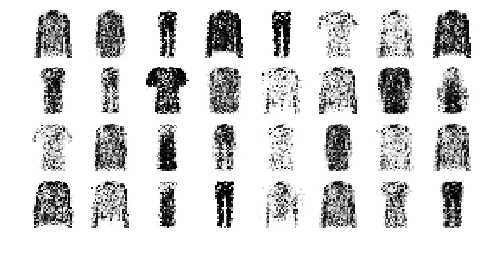

In [59]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
save_fig("gan_generated_images_plot", tight_layout=False)

Epoch 1/50


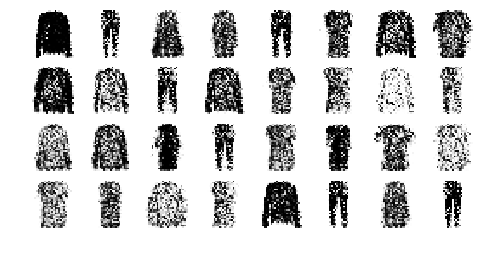

Epoch 2/50


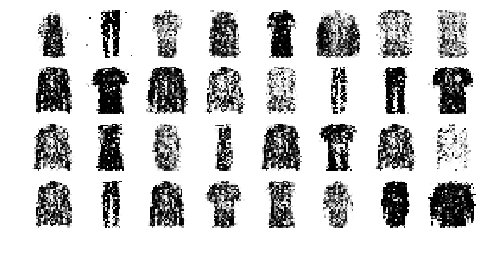

Epoch 3/50


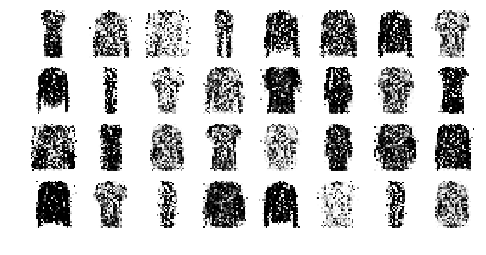

Epoch 4/50


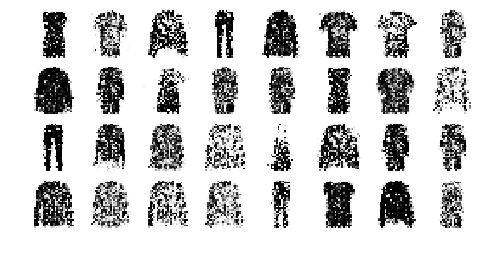

Epoch 5/50


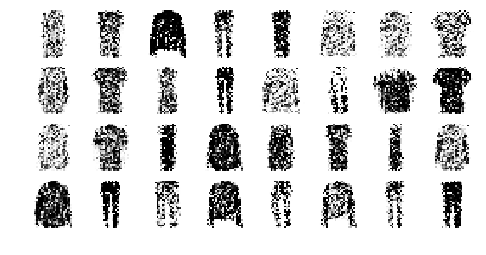

Epoch 6/50


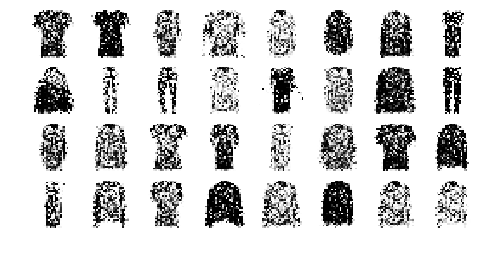

Epoch 7/50


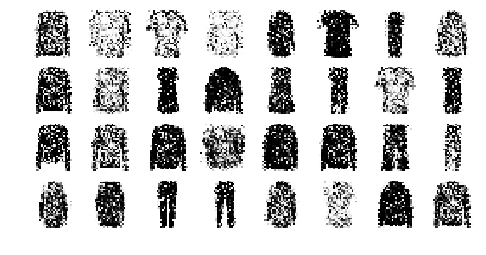

Epoch 8/50


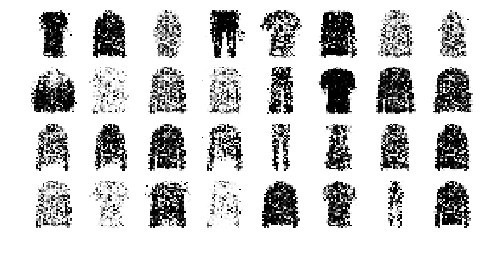

Epoch 9/50


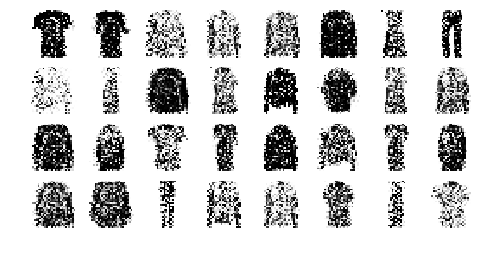

Epoch 10/50


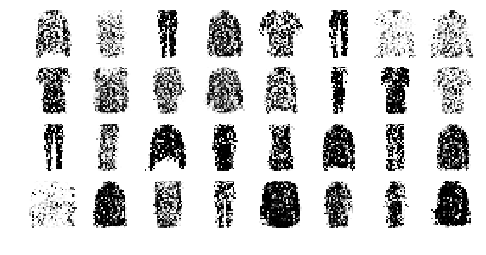

Epoch 11/50


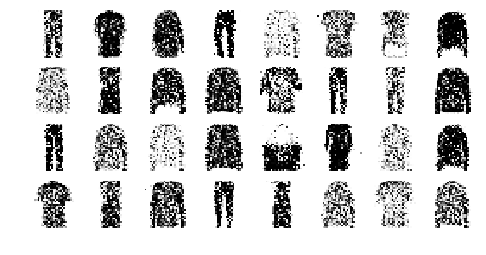

Epoch 12/50


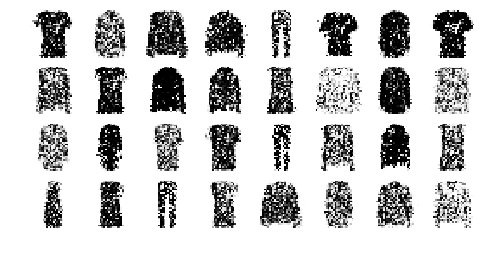

Epoch 13/50


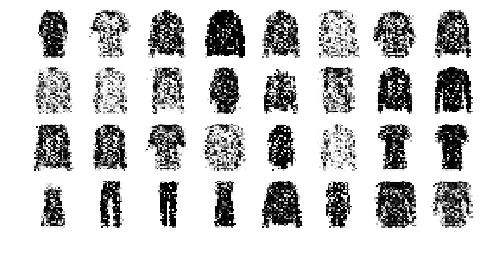

Epoch 14/50


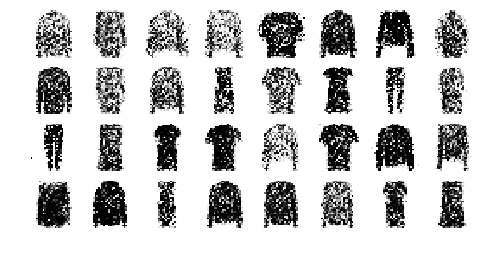

Epoch 15/50


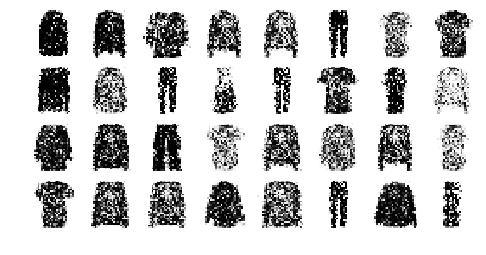

Epoch 16/50


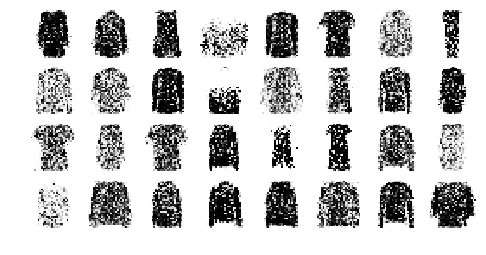

Epoch 17/50


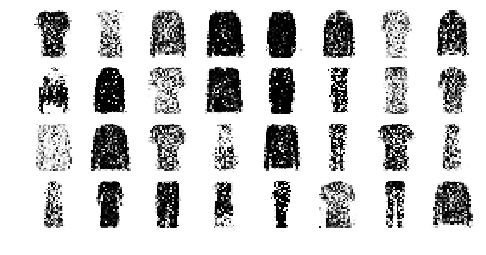

Epoch 18/50


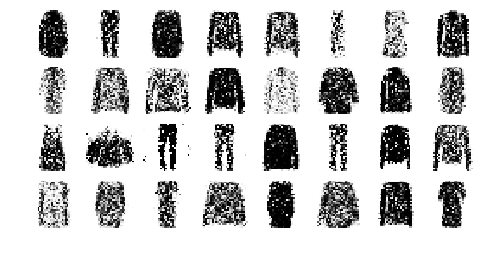

Epoch 19/50


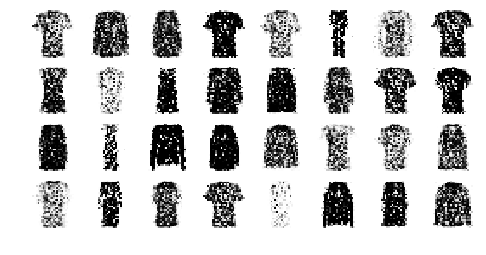

Epoch 20/50


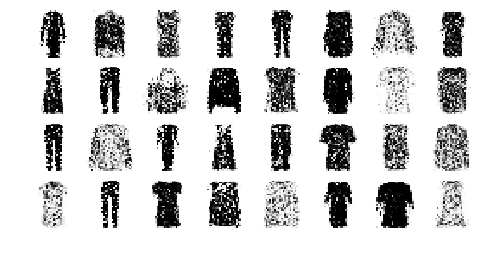

Epoch 21/50


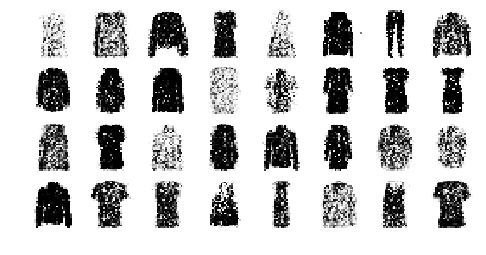

Epoch 22/50


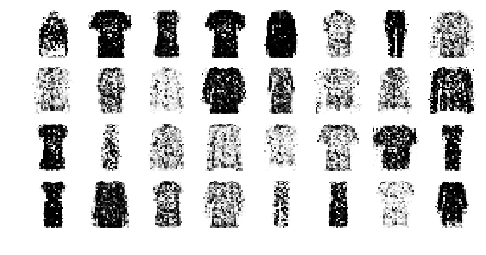

Epoch 23/50


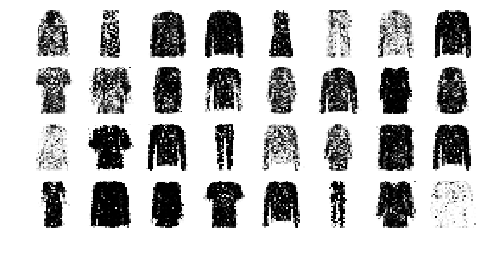

Epoch 24/50


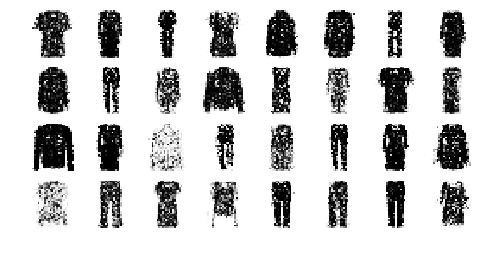

Epoch 25/50


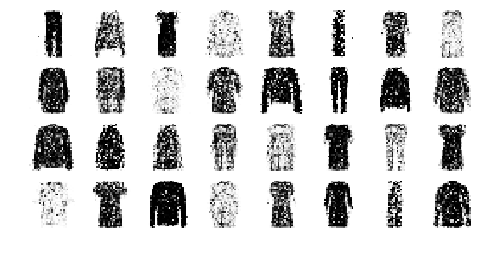

Epoch 26/50


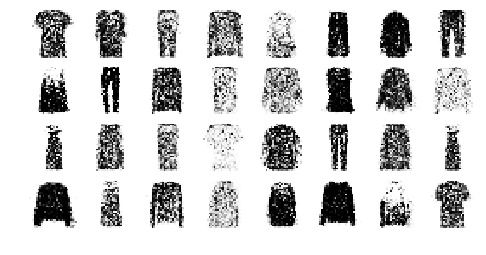

Epoch 27/50


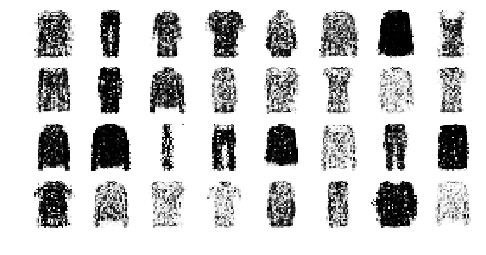

Epoch 28/50


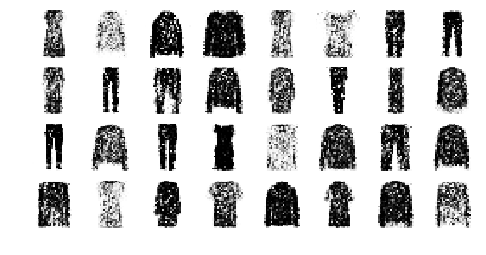

Epoch 29/50


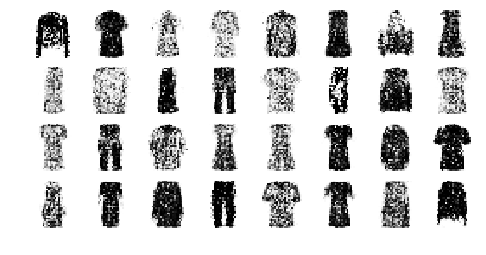

Epoch 30/50


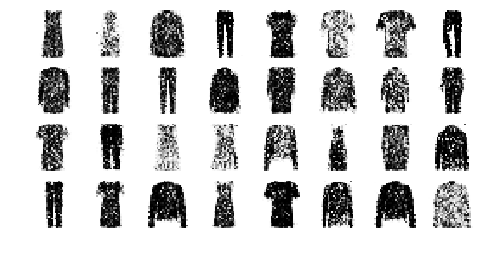

Epoch 31/50


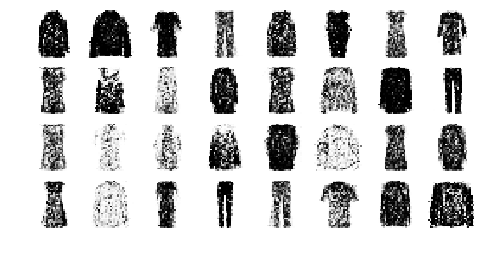

Epoch 32/50


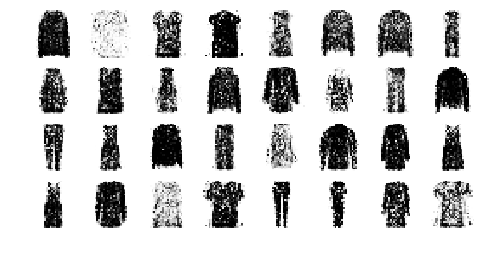

Epoch 33/50


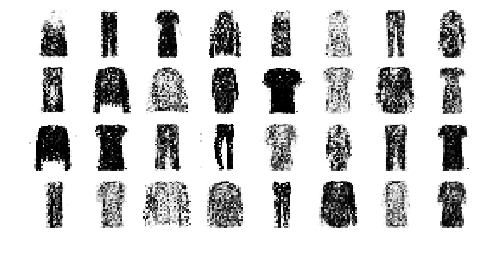

Epoch 34/50


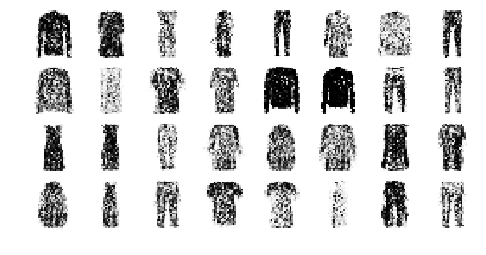

Epoch 35/50


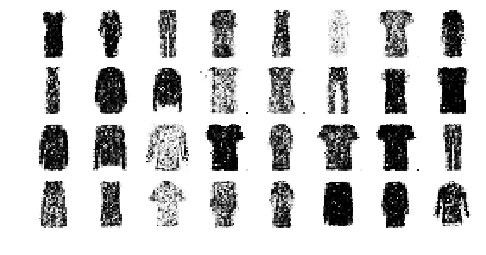

Epoch 36/50


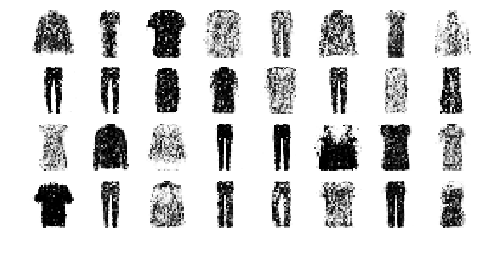

Epoch 37/50


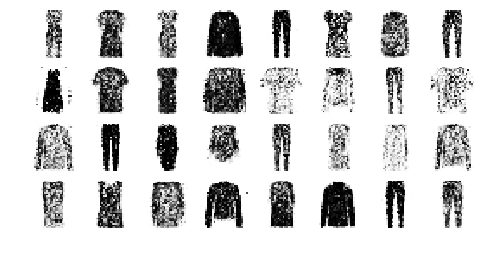

Epoch 38/50


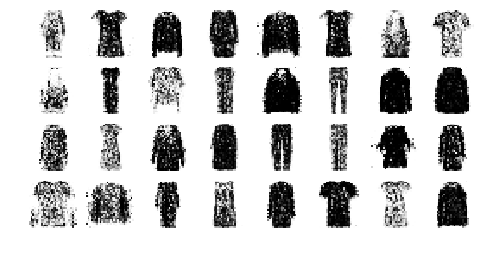

Epoch 39/50


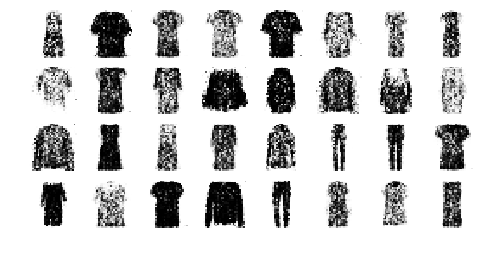

Epoch 40/50


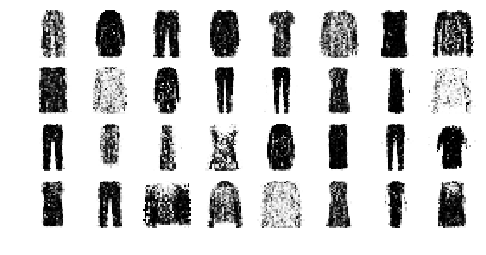

Epoch 41/50


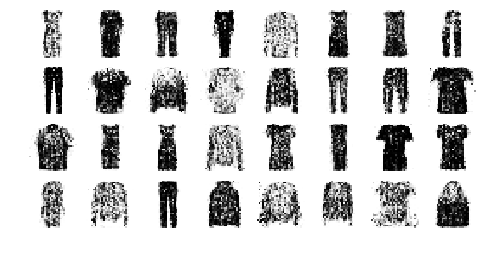

Epoch 42/50


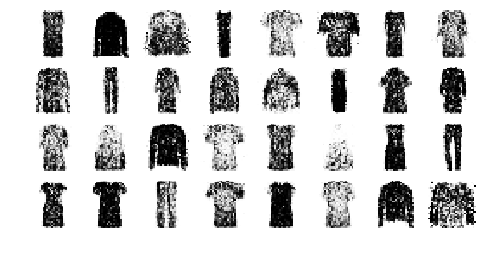

Epoch 43/50


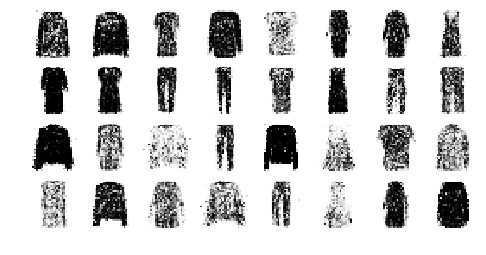

Epoch 44/50


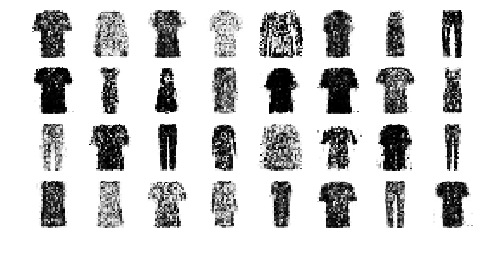

Epoch 45/50


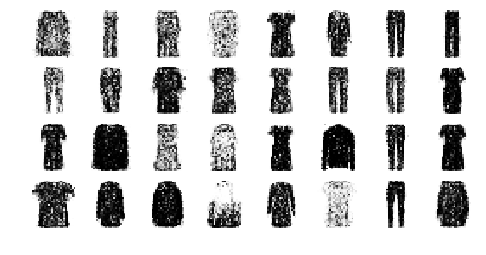

Epoch 46/50


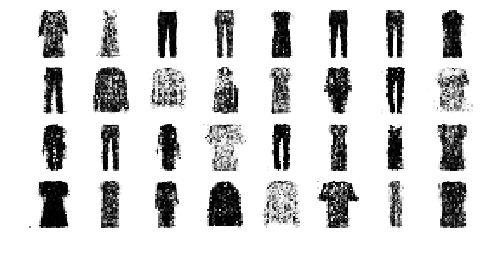

Epoch 47/50


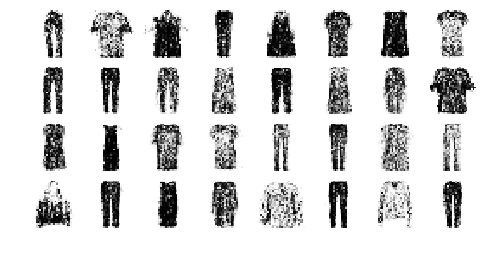

Epoch 48/50


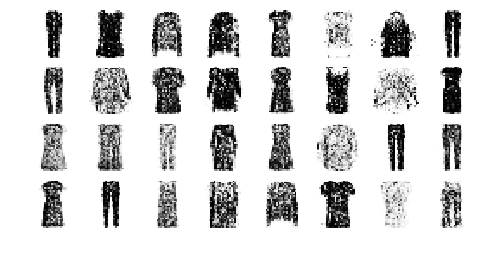

Epoch 49/50


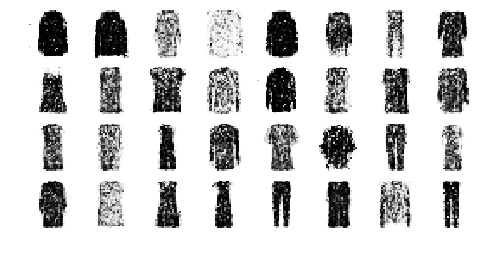

Epoch 50/50


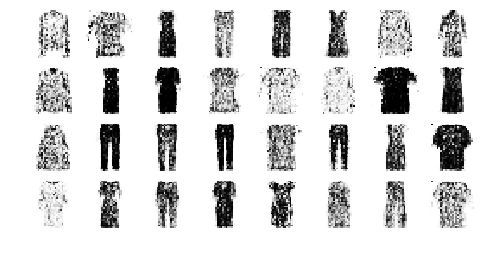

In [60]:
train_gan(gan, dataset, batch_size, codings_size)

# Deep Convolutional GAN

In [48]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [49]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [50]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale

In [51]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epoch 1/50


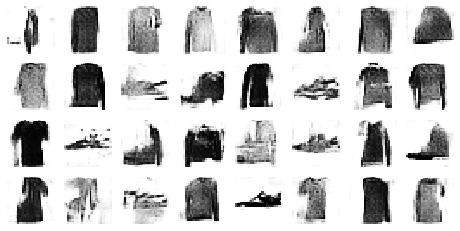

Epoch 2/50


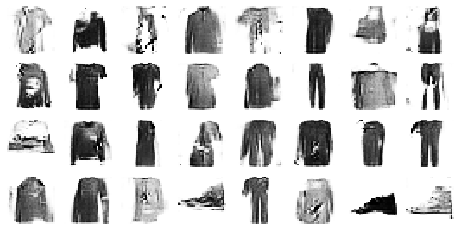

Epoch 3/50


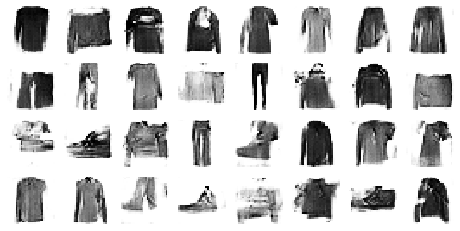

Epoch 4/50


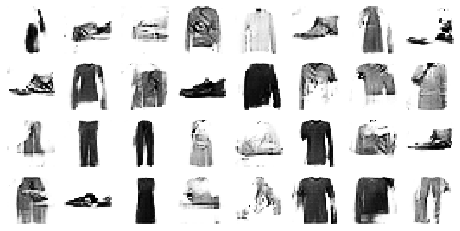

Epoch 5/50


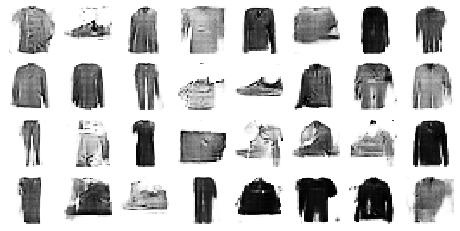

Epoch 6/50


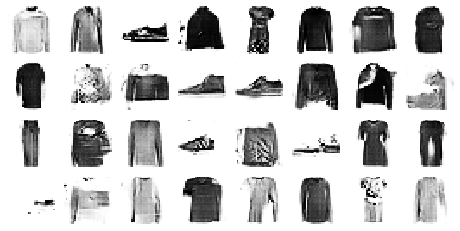

Epoch 7/50


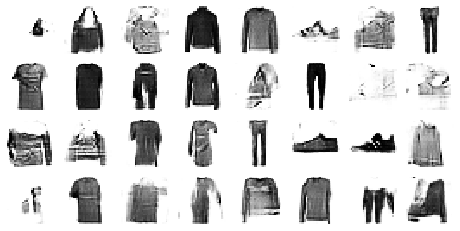

Epoch 8/50


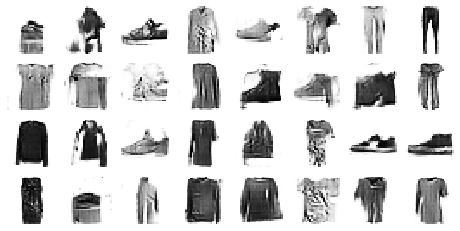

Epoch 9/50


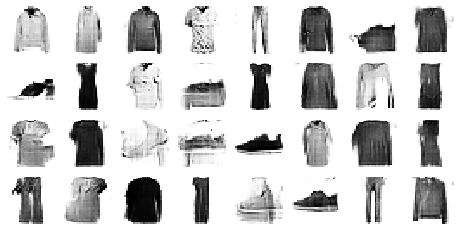

Epoch 10/50


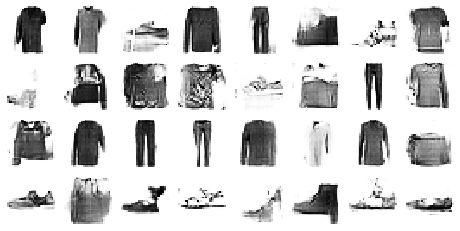

Epoch 11/50


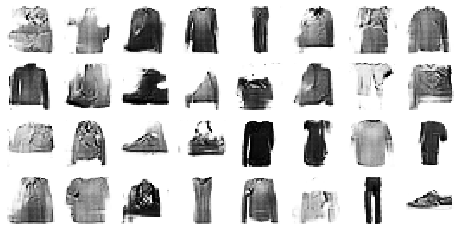

Epoch 12/50


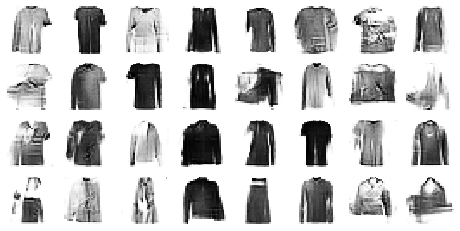

Epoch 13/50


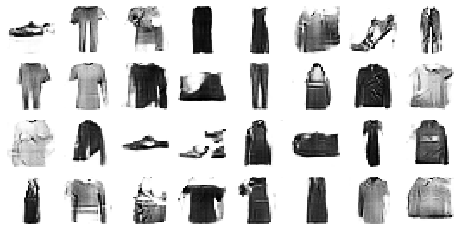

Epoch 14/50


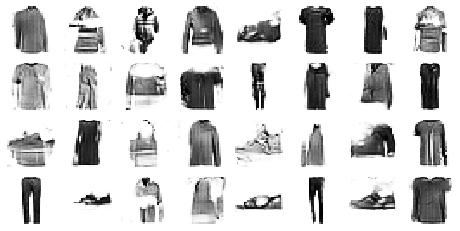

Epoch 15/50


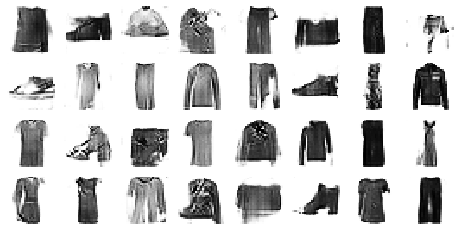

Epoch 16/50


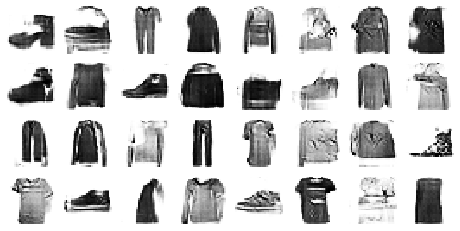

Epoch 17/50


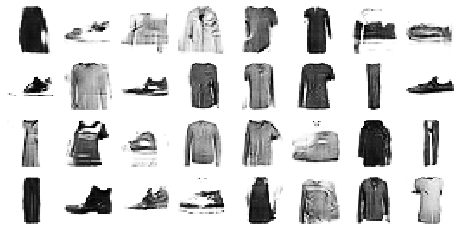

Epoch 18/50


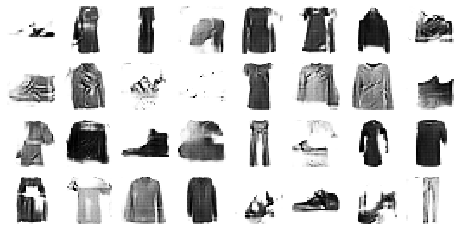

Epoch 19/50


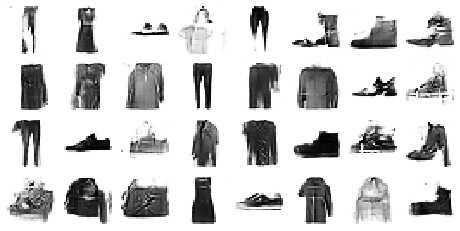

Epoch 20/50


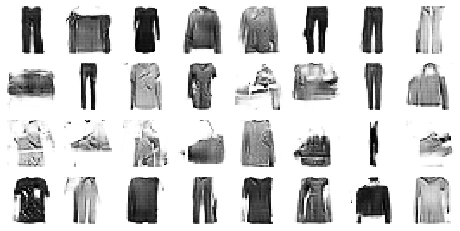

Epoch 21/50


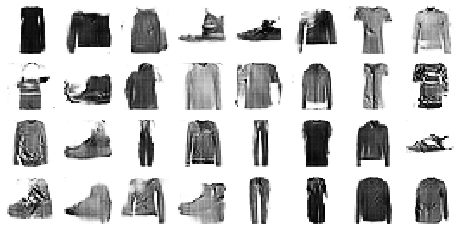

Epoch 22/50


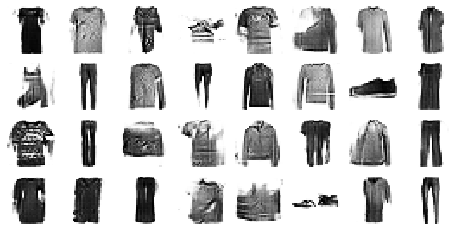

Epoch 23/50


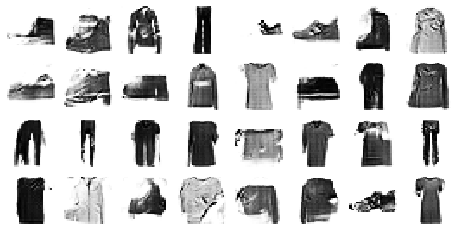

Epoch 24/50


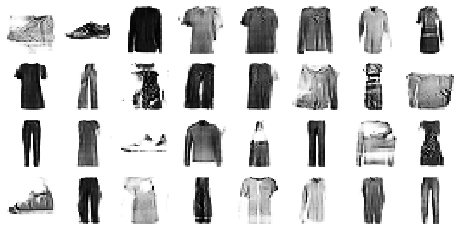

Epoch 25/50


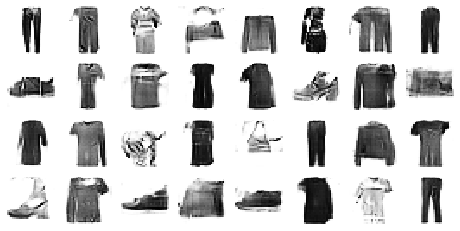

Epoch 26/50


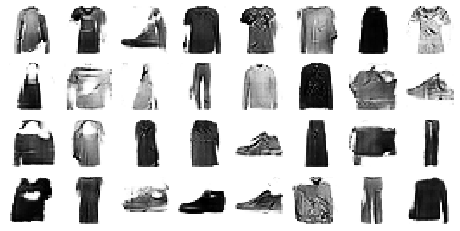

Epoch 27/50


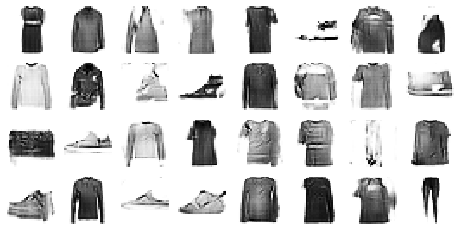

Epoch 28/50


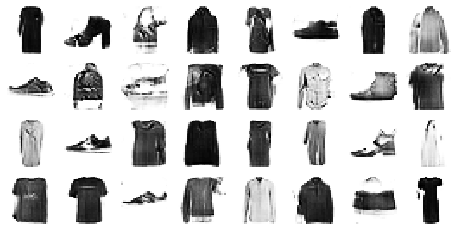

Epoch 29/50


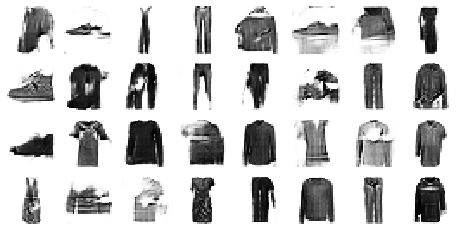

Epoch 30/50


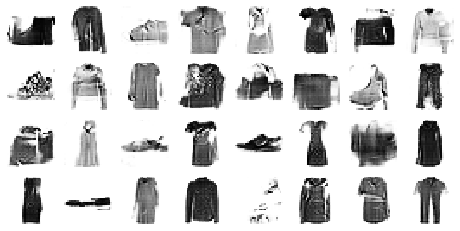

Epoch 31/50


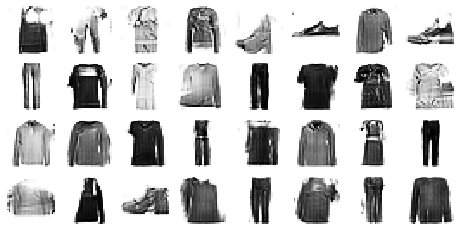

Epoch 32/50


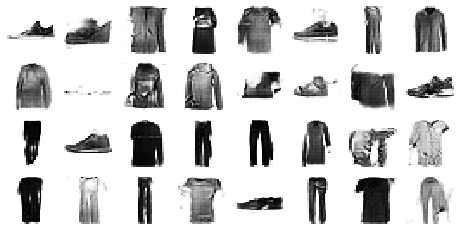

Epoch 33/50


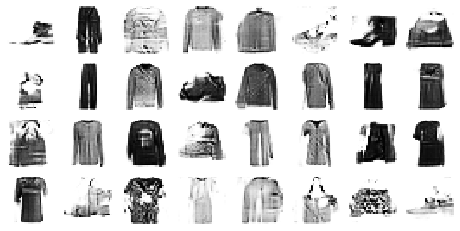

Epoch 34/50


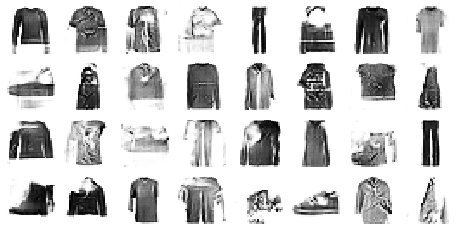

Epoch 35/50


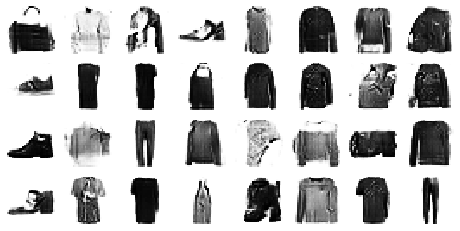

Epoch 36/50


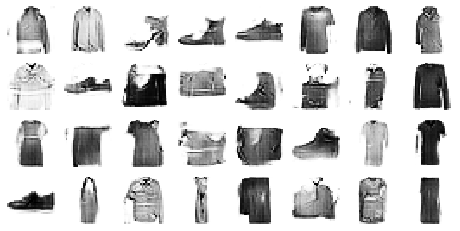

Epoch 37/50


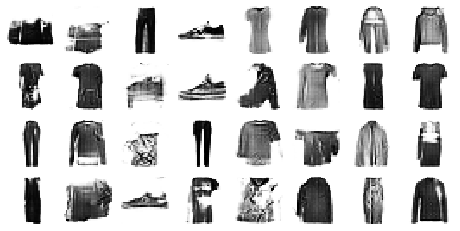

Epoch 38/50


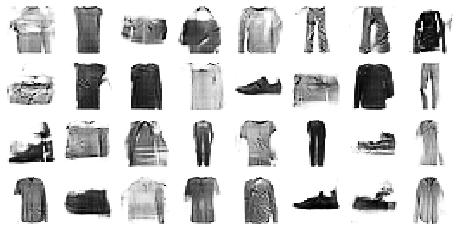

Epoch 39/50


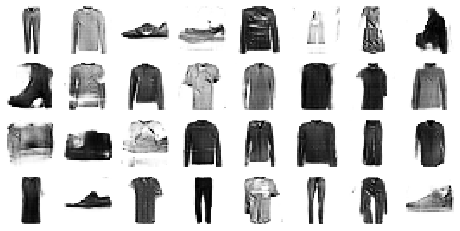

Epoch 40/50


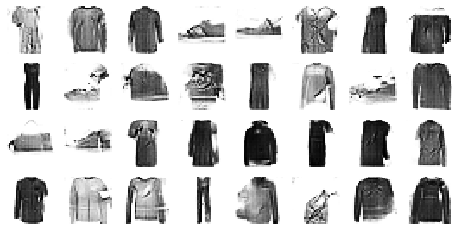

Epoch 41/50


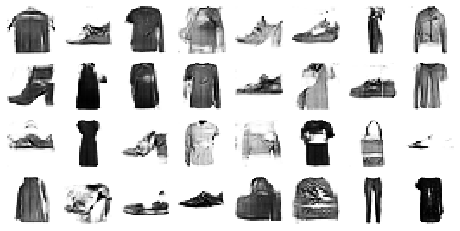

Epoch 42/50


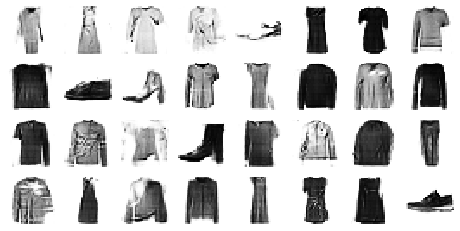

Epoch 43/50


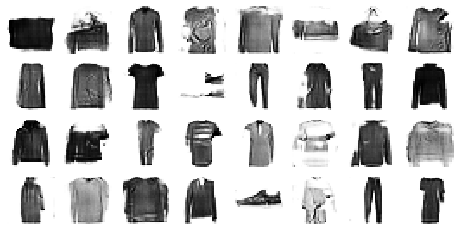

Epoch 44/50


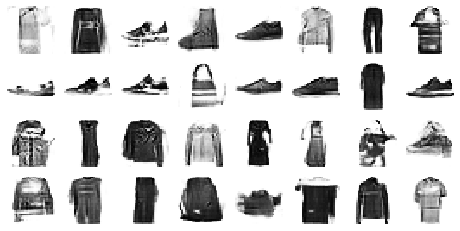

Epoch 45/50


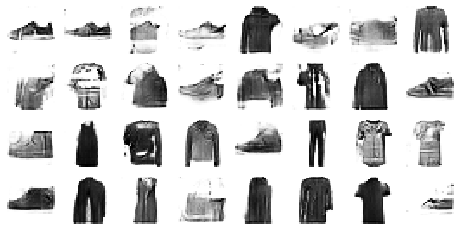

Epoch 46/50


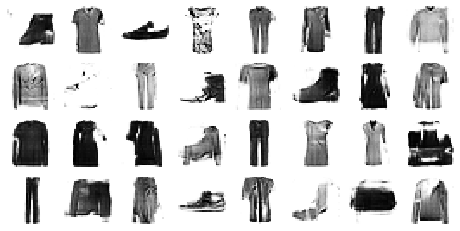

Epoch 47/50


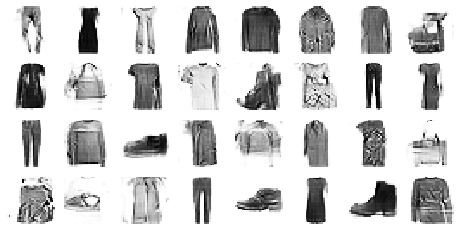

Epoch 48/50


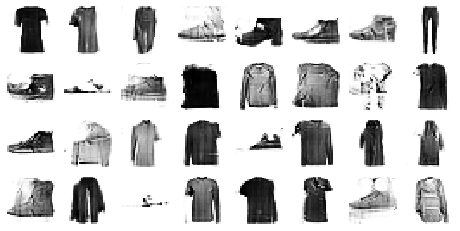

Epoch 49/50


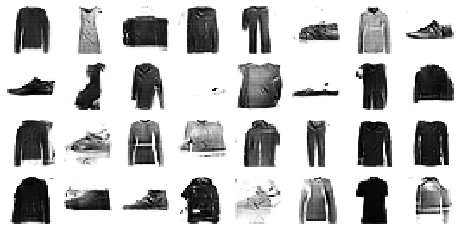

Epoch 50/50


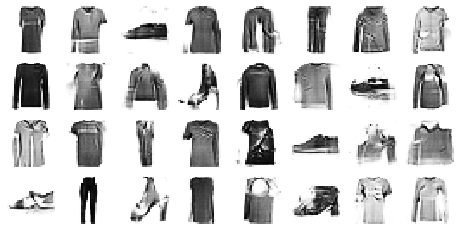

In [52]:
train_gan(gan, dataset, batch_size, codings_size)

Saving figure dcgan_generated_images_plot


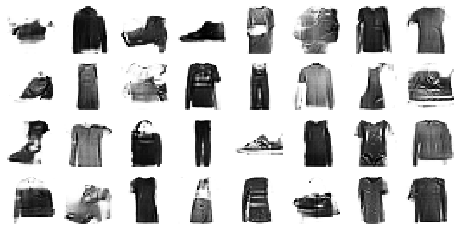

In [54]:
# tf.random.set_seed(42)
# np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
save_fig("dcgan_generated_images_plot", tight_layout=False)

# Exercise Solutions

## Unsupervised pretraining

Let's create a small neural network for MNIST classification:

In [67]:
tf.random.set_seed(42)
np.random.seed(42)

X_train_small = X_train[:500]
y_train_small = y_train[:500]

classifier = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(20, activation="selu"),
    keras.layers.Dense(10, activation="softmax")
])
classifier.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(lr=0.02),
                   metrics=["accuracy"])
history = classifier.fit(X_train_small, y_train_small, epochs=20, validation_data=[X_valid, y_valid])

Train on 500 samples, validate on 5000 samples
Epoch 1/20
500/500 [==============================] - 1s 3ms/sample - loss: 2.1965 - accuracy: 0.2480 - val_loss: 2.0234 - val_accuracy: 0.3148
Epoch 2/20
500/500 [==============================] - 1s 2ms/sample - loss: 1.7927 - accuracy: 0.5180 - val_loss: 1.5677 - val_accuracy: 0.6280
Epoch 3/20
500/500 [==============================] - 1s 2ms/sample - loss: 1.3931 - accuracy: 0.6360 - val_loss: 1.2556 - val_accuracy: 0.5482
Epoch 4/20
500/500 [==============================] - 1s 2ms/sample - loss: 1.1168 - accuracy: 0.6620 - val_loss: 0.9990 - val_accuracy: 0.6892
Epoch 5/20
500/500 [==============================] - 1s 2ms/sample - loss: 0.9421 - accuracy: 0.7360 - val_loss: 1.1235 - val_accuracy: 0.6208
Epoch 6/20
500/500 [==============================] - 1s 2ms/sample - loss: 0.8392 - accuracy: 0.7240 - val_loss: 0.8985 - val_accuracy: 0.6778
Epoch 7/20
500/500 [==============================] - 1s 2ms/sample - loss: 0.7738 - accu

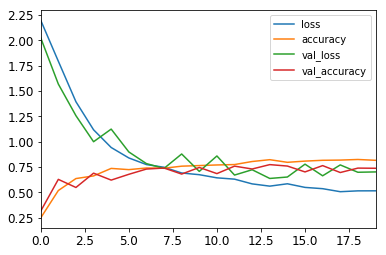

In [68]:
import pandas as pd
pd.DataFrame(history.history).plot()
plt.show()

In [69]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder_clone = keras.models.clone_model(conv_encoder)

pretrained_clf = keras.models.Sequential([
    conv_encoder_clone,
    keras.layers.Flatten(),
    keras.layers.Dense(20, activation="selu"),
    keras.layers.Dense(10, activation="softmax")
])

In [70]:
conv_encoder_clone.trainable = False
pretrained_clf.compile(loss="sparse_categorical_crossentropy",
                       optimizer=keras.optimizers.SGD(lr=0.02),
                       metrics=["accuracy"])
history = pretrained_clf.fit(X_train_small, y_train_small, epochs=30,
                             validation_data=[X_valid, y_valid])

Train on 500 samples, validate on 5000 samples
Epoch 1/30
500/500 [==============================] - 1s 3ms/sample - loss: 2.3174 - accuracy: 0.1820 - val_loss: 2.2350 - val_accuracy: 0.2156
Epoch 2/30
500/500 [==============================] - 1s 2ms/sample - loss: 2.1829 - accuracy: 0.2760 - val_loss: 2.1267 - val_accuracy: 0.3650
Epoch 3/30
500/500 [==============================] - 1s 2ms/sample - loss: 2.0852 - accuracy: 0.3880 - val_loss: 2.0370 - val_accuracy: 0.4378
Epoch 4/30
500/500 [==============================] - 1s 2ms/sample - loss: 1.9953 - accuracy: 0.4500 - val_loss: 1.9513 - val_accuracy: 0.5028
Epoch 5/30
500/500 [==============================] - 1s 2ms/sample - loss: 1.9117 - accuracy: 0.5860 - val_loss: 1.8742 - val_accuracy: 0.5610
Epoch 6/30
500/500 [==============================] - 1s 1ms/sample - loss: 1.8310 - accuracy: 0.6180 - val_loss: 1.7963 - val_accuracy: 0.6242
Epoch 7/30
500/500 [==============================] - 1s 1ms/sample - loss: 1.7526 - accu

In [71]:
conv_encoder_clone.trainable = True
pretrained_clf.compile(loss="sparse_categorical_crossentropy",
                       optimizer=keras.optimizers.SGD(lr=0.02),
                       metrics=["accuracy"])
history = pretrained_clf.fit(X_train_small, y_train_small, epochs=20,
                             validation_data=[X_valid, y_valid])

Train on 500 samples, validate on 5000 samples
Epoch 1/20
500/500 [==============================] - 1s 3ms/sample - loss: 0.8479 - accuracy: 0.7360 - val_loss: 0.8023 - val_accuracy: 0.7154
Epoch 2/20
500/500 [==============================] - 1s 2ms/sample - loss: 0.7508 - accuracy: 0.7480 - val_loss: 0.7908 - val_accuracy: 0.7062
Epoch 3/20
500/500 [==============================] - 1s 2ms/sample - loss: 0.6956 - accuracy: 0.7700 - val_loss: 0.8156 - val_accuracy: 0.7006
Epoch 4/20
500/500 [==============================] - 1s 2ms/sample - loss: 0.6806 - accuracy: 0.7700 - val_loss: 0.7408 - val_accuracy: 0.7244
Epoch 5/20
500/500 [==============================] - 1s 2ms/sample - loss: 0.6563 - accuracy: 0.7700 - val_loss: 0.6731 - val_accuracy: 0.7540
Epoch 6/20
500/500 [==============================] - 1s 2ms/sample - loss: 0.6262 - accuracy: 0.7920 - val_loss: 0.7332 - val_accuracy: 0.7316
Epoch 7/20
500/500 [==============================] - 1s 2ms/sample - loss: 0.6039 - accu

## Hashing Using a Binary Autoencoder

In [72]:
tf.random.set_seed(42)
np.random.seed(42)

hashing_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.GaussianNoise(15.),
    keras.layers.Dense(16, activation="sigmoid"),
])
hashing_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[16]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
hashing_ae = keras.models.Sequential([hashing_encoder, hashing_decoder])
hashing_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                   metrics=[rounded_accuracy])
history = hashing_ae.fit(X_train, X_train, epochs=10,
                         validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 4s 77us/sample - loss: 0.4999 - accuracy: 0.4830 - val_loss: 0.4866 - val_accuracy: 0.4815
Epoch 2/10
55000/55000 [==============================] - 4s 69us/sample - loss: 0.4780 - accuracy: 0.4892 - val_loss: 0.4768 - val_accuracy: 0.4540
Epoch 3/10
55000/55000 [==============================] - 4s 69us/sample - loss: 0.4284 - accuracy: 0.4889 - val_loss: 0.4229 - val_accuracy: 0.4757
Epoch 4/10
55000/55000 [==============================] - 4s 70us/sample - loss: 0.4088 - accuracy: 0.4895 - val_loss: 0.4195 - val_accuracy: 0.4752
Epoch 5/10
55000/55000 [==============================] - 4s 70us/sample - loss: 0.4018 - accuracy: 0.4900 - val_loss: 0.4166 - val_accuracy: 0.4751
Epoch 6/10
55000/55000 [==============================] - 4s 69us/sample - loss: 0.3971 - accuracy: 0.4905 - val_loss: 0.4170 - val_accuracy: 0.4746
Epoch 7/10
55000/55000 [==============================] -

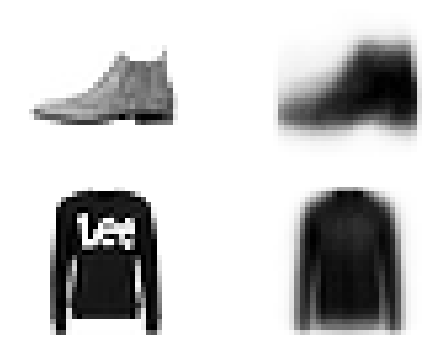

In [73]:
show_reconstructions(hashing_ae)
plt.show()

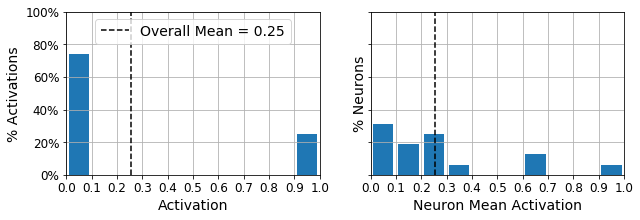

In [74]:
plot_activations_histogram(hashing_encoder)
plt.show()

In [75]:
hashes = np.round(hashing_encoder.predict(X_valid)).astype(np.int32)
hashes *= np.array([[2**bit for bit in range(16)]])
hashes = hashes.sum(axis=1)
for h in hashes[:5]:
    print("{:016b}".format(h))
print("...")

0000100100000001
0000100100000000
0000100100000001
0000100000000000
0000100000100000
...


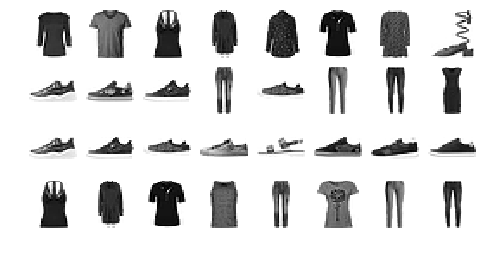

In [76]:
n_bits = 4
n_images = 8
plt.figure(figsize=(n_images, n_bits))
for bit_index in range(n_bits):
    in_bucket = (hashes & 2**bit_index != 0)
    for index, image in zip(range(n_images), X_valid[in_bucket]):
        plt.subplot(n_bits, n_images, bit_index * n_images + index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")